In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

import numpy as np
import torch
import torchio as tio
import h5py
from ipywidgets import interact
import matplotlib.pyplot as plt

dir2 = os.path.abspath('..')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: 
    sys.path.append(dir1)

In [12]:
from pathlib import Path
import pandas as pd

func_path = 'X:\\Datasets\\Deep-Image-Reconstruction\\derivatives\\fmriprep-20.2.4\\sub-01\\ses-perceptionNaturalImageTraining01\\func'
bold_file_name = 'sub-01_ses-perceptionNaturalImageTraining01_task-perception_run-2_space-T1w_desc-preproc_bold.nii.gz'
confound_file_name = 'sub-01_ses-perceptionNaturalImageTraining01_task-perception_run-1_desc-confounds_timeseries.tsv'
mask_file_name = 'sub-01_ses-perceptionNaturalImageTraining01_task-perception_run-1_space-T1w_desc-brain_mask.nii.gz'


In [4]:
from pathlib import Path
import pandas as pd

func_path = 'X:\\Datasets\\Deep-Image-Reconstruction\\sub-01\\ses-perceptionNaturalImageTraining01\\func'
bold_file_name = 'sub-01_ses-perceptionNaturalImageTraining01_task-perception_run-01_bold.nii.gz'
#confound_file_name = 'sub-01_ses-perceptionNaturalImageTraining01_task-perception_run-1_desc-confounds_timeseries.tsv'
#mask_file_name = 'sub-01_ses-perceptionNaturalImageTraining01_task-perception_run-1_space-T1w_desc-brain_mask.nii.gz'

In [13]:
bold_img = tio.ScalarImage(Path(func_path) / bold_file_name)
bold_img.load()

mask_img = tio.LabelMap(Path(func_path) / mask_file_name)
mask_img.load()

In [ ]:
bold_img.data.min(), bold_img.data.max(), bold_img.data.mean()

In [ ]:
confound_df = pd.read_csv(Path(func_path) / confound_file_name, delimiter='\t')
confound_vars = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']# 'global_signal']#, 'a_comp_cor_01', 'a_comp_cor_02']
confound_df = confound_df[confound_vars]
for col in confound_df.columns:
    confound_df[f'{col}_dt'] = confound_df[col].diff()
confound_df.to_numpy().shape

In [14]:
from nilearn import image as nimg
from nilearn import plotting as nplot
from nipy.io.api import load_image

bold_nimg = nimg.load_img(str(Path(func_path) / bold_file_name))
#mask_nimg = nimg.load_img(str(Path(func_path) / mask_file_name))
#print(bold_nimg.shape, mask_nimg.shape)

In [ ]:
start_time = 5
clean_bold_nimg = nimg.clean_img(
    bold_nimg.slicer[:, :, :, start_time:], 
    #confounds=confound_df.to_numpy()[start_time:],
    detrend=False,
    standardize=False,
    #low_pass=0.08,
    #high_pass=0.009,
    t_r=2, 
   # mask_img=mask_nimg
)

In [ ]:
from itertools import product
from obspy.signal.detrend import spline

spline_detrend = clean_bold_nimg.dataobj
for i, x in enumerate(spline_detrend.flatten(end_dim=2)):
    if i % 10000 == 0:
        print(i)
    spline(x.numpy(), order=3, dspline=25)

In [ ]:
from obspy.signal.detrend import spline

H, W, D, T = img.shape
@interact(h=(0, H-1), w=(0, W-1), d=(0, D-1))
def select(h, w, d):
    x = img[h, w, d]
    out_x = spline(x.copy(), order=3, dspline=30, plot=True)  

In [ ]:
from scipy import signal
from obspy.signal.detrend import spline

linear_detrend = signal.detrend(img.data)
linear_detrend = (linear_detrend - np.mean(linear_detrend, axis=-1, keepdims=True)) / np.std(linear_detrend, axis=-1, keepdims=True)

In [ ]:
np.std(clean_bold_nimg.dataobj)

In [ ]:
print(clean_bold_nimg.shape, bold_nimg.shape)

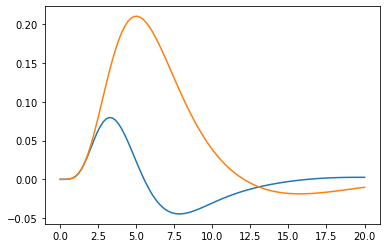

In [18]:
from nipy.modalities.fmri import hemodynamic_models
from nipy.modalities.fmri import hrf

t = np.linspace(0., 20.0, 100)
hrf_ddspmt = hrf.ddspmt(t)
hrf_dspmt = hrf.dspmt(t)
hrf_spmt = hrf.spmt(t)
plt.plot(t, hrf_dspmt, t, hrf_spmt)

In [ ]:
print(hrf_kernel)

In [22]:
import torch
import torch.nn.functional as F
from nipy.modalities.fmri import hrf

img = torch.tensor(np.array(bold_nimg.dataobj)).float().cuda()
img = torch.moveaxis(img, -1, 0)
T, H, W, D = img.shape
img = (img - img.mean()) / img.std()

k = torch.tensor([1, 1]).float().cuda()
k = k[:, None, None] * k[None, :, None] * k[None, None, :]
k = k / k.sum()
k = torch.stack([k]*T)
#img = F.conv3d(img[None], k[:, None], groups=T)[0]
print(img.shape)

tr = 2
window_end = 10
hrf_kernel = torch.tensor(hrf.dspmt(np.linspace(0.0, tr * window_end, window_end))).cuda()

@interact(d=(0, D-1), t=(0, T - 1 - window_end))
def show(d, t):
    x = img[t:t + window_end, :, :, :]
    x = x * hrf_kernel[:, None, None, None]
    x = x.sum(dim=0)
    x = x[:, :, d]
    
    fig = plt.figure(figsize=(12, 12))
    plt.imshow(x.cpu(), cmap='bwr', vmin=-0.1, vmax=0.1)
    #plt.imshow(x.cpu(), cmap='gray', vmin=-1, vmax=3)
    plt.show()
    plt.close(fig)

torch.Size([239, 81, 89, 75])


interactive(children=(IntSlider(value=37, description='d', max=74), IntSlider(value=114, description='t', max=…

In [ ]:
dataset = Kamitani2019("X:\\Datasets\\Deep-Image-Reconstruction\\")

In [ ]:
root = Path(root)
layout = BIDSLayout(root, validate=False, derivatives=True)

In [ ]:
anat = [f for f in layout.get(subject="01", scope="derivatives", extension='nii.gz', session='anatomy', suffix="T1w") 
        if "space" not in f.entities]
anat[0].get_metadata()

In [ ]:
import torchvision
imagenet = torchvision.datasets.ImageNet("X:\\Datasets\\ILSVRC2012")

In [ ]:
from bids import BIDSLayout
from research.data.kamitani_2019 import Kamitani2019, RawKamitani2019, Kamitani2019H5
from pathlib import Path

root = "X:\\Datasets\\Deep-Image-Reconstruction\\"
dataset = RawKamitani2019(root)

In [ ]:
h5_path = Path(root) / "derivatives" / "kamitani2019.hdf5"
features_path = Path(root) / "derivatives" / "RN50x16-features.hdf5"
dataset = Kamitani2019H5(h5_path, subjects=['sub-02'], func_sessions=['natural_training', 'natural_test'], 
                         window=(0, 10), drop_out_of_window_events=False,
                         features_path=features_path)
                         #folds=[0, 1, 2, 3], split='train')
    

In [ ]:
id_counts = {}
for event in dataset.events:
    stimulus_id = event['stimulus_id']
    if stimulus_id not in id_counts:
        id_counts[stimulus_id] = 1
    else:
        id_counts[stimulus_id] += 1
for stimulus_id, count in id_counts.items():
    if count != 5:
        pass
        #print(stimulus_id, count)

In [ ]:
dataset.f.close()
dataset.f_features.close()

In [ ]:
print(dataset.events[0].keys())
dataset.runs[dataset.events[0]['run_id']].name

In [ ]:
f"{int('001190'):06}"

In [ ]:
import pandas as pd
import io

with h5py.File(Path(root) / "derivatives" / 'kamitani2019.hdf5', "a") as f:
    with h5py.File(Path(root) / 'derivatives' / 'stimulus_images.hdf5', 'r') as f_stim:
        stimulus_ids = list(f_stim.keys())
        stimulus_map = {}
        for stimulus_id in stimulus_ids:
            if '.' not in stimulus_id:
                continue
            wordnet_id, dataset_id = stimulus_id.split('.')
            dataset_id = int(dataset_id)
            if wordnet_id not in stimulus_map:
                stimulus_map[wordnet_id] = []
            if dataset_id not in stimulus_map[wordnet_id]:
                stimulus_map[wordnet_id].append(dataset_id)
                
    zero_trimmed = 0
    for subject in f.values():
        for session_type, sessions in subject.items():
            if session_type not in ('natural_test', 'natural_training'):
                continue
            for run in sessions.values():
                run_event_df = pd.read_csv(io.StringIO(run.attrs['events']), index_col=0, dtype={'stimulus_id': str})
                stimulus_ids = list(run_event_df['stimulus_id'])
                
                for i, stimulus_id in enumerate(stimulus_ids):
                    if not isinstance(stimulus_id, str):
                        continue
                    wordnet_id, dataset_id = stimulus_id.split('.')
                    dataset_id = int(dataset_id)
                    if wordnet_id not in stimulus_map:
                        print(f"Invalid wordnet_id: {wordnet_id}")
                        continue
                    if dataset_id not in stimulus_map[wordnet_id]:
                        correct_dataset_id = None
                        for alt_dataset_id in (dataset_id * 10, dataset_id * 100, dataset_id * 1000):
                            if alt_dataset_id in stimulus_map[wordnet_id]:
                                correct_dataset_id = alt_dataset_id
                                run_event_df.at[i, 'stimulus_id'] = f'{wordnet_id}.{correct_dataset_id:06}'
                                zero_trimmed += 1
                                break
                        if not correct_dataset_id:
                            print(f'Invalid dataset_id={dataset_id} for wordnet_id={wordnet_id}. Valid dataset ids are: {stimulus_map[wordnet_id]}')
                            
                run.attrs['events'] = run_event_df.to_csv()
    print(zero_trimmed)
    

In [ ]:
for h5_name in ('RN50x16-features.hdf5', 'stimulus_images.hdf5'):
    with h5py.File(Path(root) / "derivatives" / h5_name, "a") as f:
        for stimulus_id in f.keys():
            if not stimulus_id.isnumeric():
                continue
            wordnet_id, dataset_id = stimulus_id[:-6], stimulus_id[-6:]
            new_stimulus_id = f'{wordnet_id}.{int(dataset_id):06}'
            f.move(stimulus_id, new_stimulus_id)

In [ ]:
dataset.f_features['4313503.20808']

In [ ]:
@interact(i=(0, len(dataset)-1))
def show_event(i):
    event = dataset[i]
    
    if 'features' in event:
        for k, v in event['features'].items():
            print(k, v.shape, v.numel())
    
    data = event['data']
    print(data.shape)
    
    H, W, D, T = data.shape
    @interact(d=(0, D-1), t=(0, T-2), derivative=False)
    def show_volume(d, t, derivative):
        fig = plt.figure(figsize=(12, 12))
        if derivative:
            x = data[:, :, d, t:t+2]
            x = x[:, :, 0] - x[:, :, 1]
            plt.imshow(x, cmap='bwr', vmin=-3, vmax=3)
        else:
            x = data[:, :, d, t]
            plt.imshow(x, cmap='gray', vmin=-1, vmax=3)
        plt.show()
        plt.close(fig)

In [ ]:
synset.name()

In [ ]:
from nltk.corpus import wordnet as wn

stimulus_images_path = Path('X:\\Datasets\\Deep-Image-Reconstruction\\derivatives\\stimulus_images')
with h5py.File(Path(root) / "derivatives" / "stimulus_images.hdf5", "w") as h5_file:
    image_paths = []
    for session_type in ('natural_test', 'natural_training', 'letter', 'artificial'):
        session_image_paths = list((stimulus_images_path / session_type).iterdir())
        image_paths += zip(session_image_paths, [session_type] * len(train_image_paths))

    for image_path, session_type in image_paths:
        with open(image_path, 'rb') as image_file:
            image = Image.open(image_file)
            image = image.convert('RGB')
            data = np.array(image)
            
        file_name = image_path.name.split('.')[0]
        attributes = {'session_type': session_type, 'file_name': file_name}
        
        if session_type in ('natural_test', 'natural_training'):
            wordnet_id, dataset_id = file_name.split('_')
            synset = wn.synset_from_pos_and_offset(wordnet_id[0], int(wordnet_id[1:]))
            attributes.update({'wordnet_id': wordnet_id, 'dataset_id': dataset_id, 'synset': synset.name()})
            stimulus_id = f'{int(wordnet_id[1:])}.{int(dataset_id)}'
        else:
            stimulus_id = file_name
        
        image_group = h5_file.create_group(stimulus_id)
        for k, v in attributes.items():
            image_group.attrs[k] = v
        image_group['data'] = data

In [ ]:
import pandas as pd
import io
from pathlib import Path
from PIL import Image
import requests

save_images_path = Path('X:\\Datasets\\Deep-Image-Reconstruction\\derivatives\\stimulus_images')

stimulus_ids = []
for run_event_df in dataset.run_event_dfs:
    stimulus_ids += list(run_event_df['stimulus_id'])

nan = stimulus_ids[0]
stimulus_ids = list(set(stimulus_ids))
stimulus_ids.remove(nan)

print(len(stimulus_ids))


                        
assert len(stimulus_map) == len(stimulus_ids)
                        
for stimulus_id in stimulus_ids:
    url, image_name = stimulus_map[stimulus_id]
    
    image_data = requests.get(url).content
    with open(save_images_path / f'{stimulus_id}.png', 'wb') as f:
        f.write(image_data)

In [ ]:
from random import Random

with h5py.File(Path(root) / "derivatives" / "kamitani2019.hdf5", "r+") as f:
    seed = 0xDEADBEEF
    num_test_runs = 20
    num_folds = 5
    
    for i, subject in enumerate(f.values()):
        runs = list(subject['natural_training'].values())
        Random(seed + i).shuffle(runs)
        test_runs = runs[:num_test_runs]
        training_runs = runs[num_test_runs:]
        for test_run in test_runs:
            test_run.attrs['test'] = True
        for i, training_run in enumerate(training_runs):
            training_run.attrs['test'] = False
            training_run.attrs['fold'] = i % num_folds

In [ ]:
with h5py.File(Path(root) / "derivatives" / "kamitani2019.hdf5", "r+") as f:
    
    for subject in f.values():
        training_runs = subject['natural_training']
        
        run_means = []
        run_stds = []
        for run in training_runs.values():
            data = run[:]
            
            run_mean = data.mean()
            run_std = data.std()
            run.attrs['mean'] = run_mean
            run.attrs['std'] = run_std
            
            run_means.append(run_mean)
            run_stds.append(run_std)
        
        training_runs.attrs['mean'] = np.mean(run_means)
        training_runs.attrs['std'] = np.mean(run_stds)

In [ ]:
for run in dataset.runs:
    print(run[:].mean())

In [ ]:
f = h5py.File(Path(root) / "derivatives" / "kamitani2019.hdf5", "r")

In [ ]:
runs = list(f['sub-02']['natural_training'].values())
runs.sort(key=lambda dset : int(dset.name.split('/')[-1]))

In [ ]:
import io
events = pd.read_csv(io.StringIO(runs[0].attrs['events']), index_col=0, dtype={'stimulus_id': str})
events = events[events['event_type'] == 1]
events.filter(items=('onset', 'stimulus_id'), axis='columns').to_dict("records")

In [ ]:
import h5py
from copy import deepcopy

with h5py.File(Path(root) / "derivatives" / "kamitani2019.hdf5", "w"DANGER) as f
    
    for subject, subject_tio in zip(dataset.subjects, dataset_tio.subjects):
        
        f.create_group(f'{subject["name"]}/anatomy/')
        
        anat_image_names = ['T1w', 'brain_mask', 'csf_mask', 'gm_mask', 'wm_mask', 
                            'LH_FFA', 'LH_hV4', 'LH_HVC', 'LH_LOC', 'LH_PPA', 'LH_V1d', 
                            'LH_V1v', 'LH_V2d', 'LH_V2v', 'LH_V3d', 'LH_V3v', 
                            'RH_FFA', 'RH_hV4', 'RH_HVC', 'RH_LOC', 'RH_PPA', 'RH_V1d', 
                            'RH_V1v', 'RH_V2d', 'RH_V2v', 'RH_V3d', 'RH_V3v']
        for anat_image_name in anat_image_names:
            anat_image = deepcopy(subject[anat_image_name])
            anat_image.load()
            anat_dset = f.create_dataset(f'{subject["name"]}/anatomy/{anat_image_name}', data=anat_image['data'])
            for k, v in anat_image.items():
                if k == 'data':
                    continue
                anat_dset.attrs[k] = v
        
        for session_type, sessions in subject['func_sessions'].items():
            print(session_type)
            for i, run_image in enumerate(sessions):
                run_image = deepcopy(run_image)
                run_image.load()
                run_dset = f.create_dataset(f'{subject["name"]}/{session_type}/{i}', data=run_image['data'])
                for k, v in run_image.items():
                    if k == 'data':
                        continue
                    if isinstance(v, pd.DataFrame):
                        v = v.to_csv()
                    run_dset.attrs[k] = v


In [ ]:
subject_ids = layout.get(return_type='id', target='subject')
subject_ids.sort()

subjects = []
for subject_id in subject_ids:
    subject = {
        'name': f'sub-{subject_id}',
        'func_sessions': {}
    }
    subjects.append(subject)
    
    session_ids = layout.get(return_type='id', subject=subject_id, target='session')
    session_info = [
        ('imagery', 'imagery'),
        ('artificial', 'perceptionArtificialImage'),
        ('letter', 'perceptionLetterImage'),
        ('natural_test', 'perceptionNaturalImageTest'),
        ('natural_training', 'perceptionNaturalImageTraining'),
    ]
    
    for func_session_type, func_session_name in session_info:
        print(func_session_type)
        subject['func_sessions'][func_session_type] = runs = []
        
        session_ids_of_type = [session_id for session_id in session_ids 
                               if session_id.startswith(func_session_name)]
        bold_files = layout.get(subject=subject_id, suffix='bold', extension='nii.gz', session=session_ids_of_type, 
                                space='T1w', scope='derivatives')
        
        for bold_file in bold_files:
            entities = bold_file.get_entities()
            
            events_file = layout.get(subject=subject_id, run=entities['run'], session=entities['session'], suffix='events')
            assert len(events_file) == 1
            events = events_file[0].get_df()
            
            confounds_file = layout.get(subject=subject_id, run=entities['run'], session=entities['session'], desc='confounds', extension='tsv')
            assert len(confounds_file) == 1
            confounds = confounds_file[0].get_df()
            
            metadata = bold_file.get_metadata()
            bold_img = tio.ScalarImage(bold_file.path, events=events, confounds=confounds, **metadata)
            runs.append(bold_img)

In [ ]:
#subjects[2]['func_sessions']['natural_training']

In [ ]:
for subject in subjects:
    print(subject['name'])
    for session_type, runs in subject['func_sessions'].items():
        print(f'{session_type}, num runs: {len(runs)}')
        print("events per run:", [np.sum(img['events']['event_type'] == 1) for img in runs])

In [ ]:
bold_sessions = layout.get_sessions()
bold_sessions.remove('anatomy')
for session in bold_sessions:
    #runs = layout.get(return_type='id', subject='01',)
    #print(runs)
    bids_files = layout.get(subject='01', session=session, suffix='bold', extension='nii.gz', run=1)
    print(*bids_files, sep='\n')

In [ ]:
bids_files[0].get_entities()

In [ ]:
layout.get(return_type='id', target='run', subject='01', session='perceptionNaturalImageTraining03')

In [ ]:
layout.get(subject='01',  suffix='events')

In [ ]:
import json
from pathlib import Path

out_path = Path('./fmriprep_jobs/')
for subject in dataset.subjects:
    
    subject_path = out_path / subject.name
    subject_path.mkdir(parents=True, exist_ok=True)
    
    session_paths = list((dataset.root / subject.name).iterdir())
    session_names = [p.name.split('-')[1] for p in session_paths]
    session_names.remove('anatomy')
    
    for i, session_name in enumerate(session_names):
        job_filter = {"bold": {"datatype": "func", "session": session_name, "suffix": "bold"}}
        with (subject_path / f'job-{i}.json').open('w') as f:
            json.dump(job_filter, f)

In [ ]:
from research.data.kamitani_2019 import Kamitani2019

dataset = Kamitani2019("X:\\Datasets\\Deep-Image-Reconstruction\\")

subject = dataset.subjects[0]
subject['t1']

In [ ]:
from nipy.core.image.image import Image
from nipy.core.reference.coordinate_map import AffineTransform, CoordinateSystem
from nipy.io.api import load_image

subject = dataset.subjects[0]
session = subject['sessions']['natural_training'][0]
t1 = subject['t1']
t2 = session['t2']
bold = session['runs'][0]

t1_nipy = load_image(str(t1.path))
t2_nipy = load_image(str(t2.path))
bold_nipy = load_image(str(bold.path))

In [ ]:
t1_registration = HistogramRegistration(t2_nipy, t1_nipy)
affine = t1_registration.optimize('rigid')
t2_resampled_nipy = resample(t2_nipy, affine.inv())

#save_image(t2_resampled_nipy, "t2_registered.nii.gz")

In [ ]:
t2_rigid_registered = copy.deepcopy(t2_nipy)
t2_rigid_registered.affine = t2_rigid_registered.affine @ affine.as_affine()
save_image(t2_resampled_nipy, "t2_registered_no_resample.nii.gz")

In [ ]:
from nipy.algorithms.registration import HistogramRegistration, resample
import time

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

affines = []
for i in range(bold_nipy.shape[3]):
    t2_registration = HistogramRegistration(bold_nipy[:, :, :, i], t2_nipy)
    with HiddenPrints():
        affine = t2_registration.optimize('rigid')
    affines.append(affine)
    #bold_registered = resample(bold_nipy[:, :, :, i], affine.inv())
    #registered.append(bold_registered)
    if i % 25 == 0:
        print(f'{i}/{bold_nipy.shape[3]}')

In [ ]:
from nipy.algorithms.registration import SpaceTimeRealign
bold_data = bold['bold_data']
space_time_realign = SpaceTimeRealign(bold_nipy, tr=bold_data['RepetitionTime'], slice_times=bold_data['SliceTiming'], slice_info=2)
space_time_realign.estimate()

In [ ]:
corr_run = space_time_realign.resample(0)

In [ ]:
corr_run.shape

In [ ]:
save_image(registered_nipy, "registered_spacetime.nii.gz")

In [ ]:
registered = []
for i in range(bold_nipy.shape[3]):
    print(i)
    bold_registered = resample(bold_nipy[:, :, :, i], affines[i].inv())
    registered.append(bold_registered)

In [ ]:
out_data = np.stack([r[:] for r in registered], -1)
out_data.shape

In [ ]:
from nipy.io.api import save_image
registered_nipy = copy.deepcopy(bold_nipy)
registered_nipy[:] = out_data
save_image(registered_nipy, "registered_rigid.nii.gz")

In [ ]:

print(bold_registered.coordmap)
print(bold_nipy[:, :, :, 0].coordmap)

In [ ]:
transform.data


In [ ]:
import copy

def copy_and_load(image):
    image = copy.deepcopy(image)
    image.load()
    return image

def vis_kamitani2019(dataset):
    
    @interact(i=(0, 2))
    def select_subject(i):
        subject = dataset.subjects[i]
        
        t1 = copy_and_load(subject['t1'])
        t1 = tio.ToCanonical()(t1)
        
        @interact(session_type=subject['sessions'])
        def select_session_type(session_type):
            
            @interact(session_id=(0, len(session_type) - 1))
            def select_session(session_id):
                
                session = session_type[session_id]
                t2 = copy_and_load(session['t2'])
                t2 = tio.ToCanonical()(t2)
                
                @interact(run_id=(0, len(session['runs']) - 1))
                def select_run(run_id):
                    
                    bold = copy_and_load(session['runs'][run_id])
                    bold.shape
                    bold = tio.ToCanonical()(bold)
                    print(bold)

                    @interact(d=(0, t1.shape[3] - 1))
                    def plot_t1(d):

                        x = (t1['data'][0, :, :, d] - t1['data'].mean()) / t1['data'].std()
                        fig = plt.figure(figsize=(8, 8))
                        plt.imshow(x, cmap="gray", vmin=-1, vmax=4)
                        plt.colorbar()
                        plt.show()
                        plt.close(fig)
    print('test')
    
vis_kamitani2019(dataset)

In [ ]:
from nireg import HistogramRegistration

In [ ]:
from nipy.algorithms.registration import HistogramRegistration

affine.Affine()

In [ ]:
sessions = dataset.subjects[0]['sessions']['natural_training']
session = sessions[0]
runs = session['runs']
for subject in dataset.subjects:
    print(subject['name'])
    for session_type, session_data in subject['sessions'].items():
        print(f'{session_type}, num_sessions={len(session_data)}, {[len(session["runs"]) for session in session_data]}')
    print()

In [ ]:
from pathlib import Path
roi_folder = Path("X:\\Datasets\\Deep-Image-Reconstruction\\sourcedata\\sub-01\\anat")

file_names = tuple(p.name.split('.')[0] for p in roi_folder.iterdir())
split_names = [file_name.split('_') for file_name in file_names]
roi_name = [f'{split_name[2]}_{split_name[3]}' for split_name in split_names]
print(tuple(roi_name))

In [ ]:
Path('foo/bar/ree').relative_to('foo')

In [ ]:
(root / "test.nii.gz").stem

In [ ]:
import gzip
import shutil
from pathlib import Path

root = Path('X:\\Datasets\\Deep-Image-Reconstruction\\')
unzipped = Path('X:\\Datasets\\Deep-Image-Reconstruction-Unzipped\\')

def unzip(path):
    if path.is_dir():
        for p in path.iterdir():
            unzip(p)
    
    if path.is_file():
        out_path = unzipped / path.relative_to(root)
        out_path.parent.mkdir(exist_ok=True, parents=True)
        
        if path.suffix == '.gz':
            print("unzipping", path)
            out_path = out_path.parent / path.stem

            with gzip.open(path, 'rb') as f_in:
                with open(out_path, 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)
        else:
            shutil.copyfile(path, out_path)
    
                
unzip(root)